In [1]:
from __future__ import division
import os
import time
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.layers import Layer, InputSpec, Conv2D, Conv2DTranspose, Activation, Reshape, BatchNormalization, AveragePooling2D
from tensorflow.keras.layers import Input, UpSampling2D, Dropout, Concatenate, add, Dense, Multiply, LeakyReLU, ReLU, Flatten, Dot, Embedding
from tensorflow.keras import initializers, regularizers, constraints, Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model

In [2]:
# from csv file
train = pd.read_csv("../../mnist/data/train.csv")
test = pd.read_csv("../../mnist/data/test.csv")

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
labels = train['label']
train_data = train.drop("label", axis=1)

In [5]:
train_data.shape

(42000, 784)

In [6]:
train_data = (train_data.values.reshape(-1, 28, 28, 1) - 127.5) / 127.5
#train_data = train_data.values / 255.

In [7]:
train_data

array([[[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        ...,

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]]],


       [[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [

In [8]:
train_data.shape

(42000, 28, 28, 1)

In [9]:
classes = np.sort(labels.unique())
oh_labels = to_categorical(labels, num_classes=len(classes))

In [10]:
labels = labels.values.reshape((-1, 1))

In [11]:
oh_labels.shape

(42000, 10)

In [12]:
labels.shape

(42000, 1)

In [14]:
OUTPUT_PATH = 'outputs'
TRAIN_LOGDIR = os.path.join("logs", "tensorflow", 'train_data') # Sets up a log directory.
#TEST_LOGDIR = os.path.join("logs", "tensorflow", 'test_data') # Sets up a log directory.
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

BATCH_SIZE = 64
NOISE_DIM = 100

ITERATIONS = 100000
DECAY_ITERATIONS = 80000
CURRENT_ITERATION = 1 # Epoch start from
SAVE_EVERY_N_ITER = 5000 # Save checkpoint at every n epoch

D_G_TRAINING_RATIO = 5
LR = 0.0002
BETA_1 = 0.0
BETA_2 = 0.9

MIN_LR = 0.000001
DECAY_FACTOR=1.00004

# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)
#test_file_writer = tf.summary.create_file_writer(TEST_LOGDIR)

In [15]:
class ConditionalBatchNormalization(Model):
    """
    https://github.com/crcrpar/pytorch.sngan_projection/blob/master/links/conditional_batchnorm.py
    Conditional Batch Normalization Base Class
    """

    def __init__(self, 
               num_classes,
               units,
               axis=-1,
               momentum=0.99,
               epsilon=1e-3,
               center=False,
               scale=False,
               beta_initializer='zeros',
               gamma_initializer='ones',
               moving_mean_initializer='zeros',
               moving_variance_initializer='ones',
               beta_regularizer=None,
               gamma_regularizer=None,
               beta_constraint=None,
               gamma_constraint=None,
               renorm=False,
               renorm_clipping=None,
               renorm_momentum=0.99,
               fused=None,
               trainable=True,
               virtual_batch_size=None,
               adjustment=None,
               name=None,
               **kwargs):
        super(ConditionalBatchNormalization, self).__init__(name, **kwargs)
        self.weight_embedding = Embedding(input_dim=num_classes, output_dim=units, input_length=1, embeddings_initializer='ones')
        self.bias_embedding = Embedding(input_dim=num_classes, output_dim=units, input_length=1, embeddings_initializer='zeros')
        self.bn = BatchNormalization(axis=-1,
               momentum=0.99,
               epsilon=1e-3,
               center=False,
               scale=False,
               beta_initializer='zeros',
               gamma_initializer='ones',
               moving_mean_initializer='zeros',
               moving_variance_initializer='ones',
               beta_regularizer=None,
               gamma_regularizer=None,
               beta_constraint=None,
               gamma_constraint=None,
               renorm=False,
               renorm_clipping=None,
               renorm_momentum=0.99,
               fused=None,
               trainable=True,
               virtual_batch_size=None,
               adjustment=None,)

    def call(self, inputs, training=None):
        """Call `Layer`"""
        
        class_weights = self.weight_embedding(inputs[1])
        class_bias = self.bias_embedding(inputs[1])

        if len(class_weights.shape) == 3:
            class_weights = tf.squeeze(class_weights, [1])
        if len(class_bias.shape) == 3:
            class_bias =tf.squeeze(class_bias, [1])
        
        output = self.bn(inputs[0], training=training)
        
        if len(class_weights.shape) == 1:
            class_weights = tf.expand_dims(class_weights, 0)
        if len(class_bias.shape) == 1:
            class_bias = tf.expand_dims(class_bias, 0)
            
        
        class_weights = class_weights[:, tf.newaxis, tf.newaxis, :]
        class_bias = class_bias[:, tf.newaxis, tf.newaxis, :]
        output = class_weights * output + class_bias
        return output
    
    def compute_output_shape(self, input_shape):
        return tensor_shape.TensorShape(input_shape[0])

class SpectralNormalization(tf.keras.layers.Wrapper):
    """
    Reference from WeightNormalization implementation of TF Addons
    SpectralNormalization wrapper works for keras CNN and Dense (RNN not tested).
    ```python
      net = SpectralNormalization(
          tf.keras.layers.Conv2D(2, 2, activation='relu'),
          input_shape=(32, 32, 3))(x)
    ```
    Arguments:
      layer: a layer instance.
    Raises:
      ValueError: If `Layer` does not contain a `kernel` of weights
    """

    def __init__(self, layer, power_iter=1, **kwargs):
        super(SpectralNormalization, self).__init__(layer, **kwargs)
        self._track_trackable(layer, name='layer')
        self.power_iter = 1
        self.is_rnn = isinstance(self.layer, tf.keras.layers.RNN)
        self.is_embedding = isinstance(self.layer, tf.keras.layers.Embedding)

    def build(self, input_shape):
        """Build `Layer`"""
        input_shape = tf.TensorShape(input_shape)
        self.input_spec = tf.keras.layers.InputSpec(
            shape=[None] + input_shape[1:])

        if not self.layer.built:
            self.layer.build(input_shape)

        if self.is_rnn:
            kernel_layer = self.layer.cell
        else:
            kernel_layer = self.layer

        if not hasattr(kernel_layer, 'kernel') and not hasattr(kernel_layer, 'embeddings'):
            raise ValueError('`SpectralNormalization` must wrap a layer that'
                             ' contains a `kernel or embedding` for weights')

        if self.is_rnn:
            kernel = kernel_layer.recurrent_kernel
        elif self.is_embedding:
            kernel = kernel_layer.embeddings
        else:
            kernel = kernel_layer.kernel
            
        self.kernel_shape = kernel.shape
        
        self.u = self.add_weight(name='u',
                             shape=(self.kernel_shape[-1], 1),
                             initializer='random_normal',
                             trainable=False)
        self.w = kernel
        self.built = True
    
    def call(self, inputs, training=True):
        """Call `Layer`"""

        with tf.name_scope('compute_weights'):
            
            weight = tf.reshape(self.w, shape=[self.kernel_shape[-1], -1])
            # power iteration
            for i in range(self.power_iter):
                v = K.l2_normalize(tf.matmul(tf.transpose(weight), self.u))
                u = K.l2_normalize(tf.matmul(weight, v))
            v = tf.stop_gradient(v)
            u = tf.stop_gradient(u)
            
            sigma = tf.matmul(tf.matmul(tf.transpose(u), weight), v)
            kernel = self.w / sigma

            if self.is_rnn:
                print(self.is_rnn)
                self.layer.cell.recurrent_kernel = kernel
                update_kernel = tf.identity(self.layer.cell.recurrent_kernel)
            else:
                self.layer.kernel = kernel
                update_kernel = tf.identity(self.layer.kernel)

            # Ensure we calculate result after updating kernel.
            with tf.control_dependencies([update_kernel]):
                outputs = self.layer(inputs)
                return outputs

    def compute_output_shape(self, input_shape):
        return tf.TensorShape(
            self.layer.compute_output_shape(input_shape).as_list())
    
class GlobalSumPooling2D(Layer):
    def __init__(self, data_format='channels_last', **kwargs):
        super(GlobalSumPooling2D, self).__init__(**kwargs)
        self.input_spec = InputSpec(ndim=4)
        self.data_format = conv_utils.normalize_data_format(data_format)
    
    def call(self, inputs):
        if self.data_format == 'channels_last':
            return K.sum(inputs, axis=[1, 2])
        else:
            return K.sum(inputs, axis=[2, 3])
    
    def get_config(self):
        config = {'data_format': self.data_format}
        base_config = super(GlobalSumPooling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def compute_output_shape(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape).as_list()
        if self.data_format == 'channels_last':
            return tensor_shape.TensorShape([input_shape[0], input_shape[3]])
        else:
            return tensor_shape.TensorShape([input_shape[0], input_shape[1]])

In [16]:
def upsample_residual_block(inputs, in_filters, filters, kernel_size=3, strides=1, padding='same',
                            activation=tf.nn.leaky_relu, upsample=True, name=''):
    '''
        Upsampling Residual Block
    '''
    kernel_initializer = 'glorot_uniform'
    x_input, class_input = inputs
    
    x = ConditionalBatchNormalization(num_classes=len(classes), units=in_filters)([x_input, class_input])
    x = Activation(activation)(x)
    if upsample:
        x = UpSampling2D(size=2, interpolation='nearest')(x)
    x = Conv2D(filters, kernel_size, strides, padding=padding,
                   kernel_initializer=kernel_initializer)(x)
    
    x = ConditionalBatchNormalization(num_classes=len(classes), units=filters)([x, class_input])
    x = Activation(activation)(x)
    x = Conv2D(filters, kernel_size, strides, padding=padding, kernel_initializer=kernel_initializer)(x)
    
    if in_filters != filters or upsample:
        if upsample:
            x_input = UpSampling2D(size=2, interpolation='nearest')(x_input)
        x_input = Conv2D(filters, 1, 1, padding='valid',
                   kernel_initializer=kernel_initializer)(x_input)
    
    x += x_input
    return x

def initial_downsample_block(inputs, in_filters, filters, kernel_size=3, strides=1, padding='same',
                              activation=tf.nn.leaky_relu, name=''):
    '''
        Downsampling Residual Block
    '''
    kernel_initializer = 'glorot_uniform'
    x_input = inputs

    x = SpectralNormalization(Conv2D(filters, kernel_size, strides, padding=padding,
                   kernel_initializer=kernel_initializer))(x_input)
    x = Activation(activation)(x)
    x = SpectralNormalization(Conv2D(filters, kernel_size, strides, padding=padding, kernel_initializer=kernel_initializer))(x)
    
    x = AveragePooling2D(pool_size=2)(x)
    
    x_input = AveragePooling2D(pool_size=2)(x_input)
    x_input = SpectralNormalization(Conv2D(filters, 1, 1, padding='valid',
                   kernel_initializer=kernel_initializer))(x_input)
    
    x += x_input
    return x

def downsample_residual_block(inputs, in_filters, filters, kernel_size=3, strides=1, padding='same',
                              activation=tf.nn.leaky_relu, downsample=True, name=''):
    '''
        Downsampling Residual Block
    '''
    kernel_initializer = 'glorot_uniform'
    x_input = inputs

    x = Activation(activation)(x_input)
    x = SpectralNormalization(Conv2D(filters, kernel_size, strides, padding=padding,
                   kernel_initializer=kernel_initializer))(x)
    
    x = Activation(activation)(x)
    x = SpectralNormalization(Conv2D(filters, kernel_size, strides, padding=padding, kernel_initializer=kernel_initializer))(x)
    
    if downsample:
        x = AveragePooling2D(pool_size=2)(x)
    
    if in_filters != filters or downsample:
        x_input = SpectralNormalization(Conv2D(filters, 1, 1, padding='valid',
                   kernel_initializer=kernel_initializer))(x_input)
        if downsample:
            x_input = AveragePooling2D(pool_size=2)(x_input)

    x += x_input
    return x

In [17]:
# activation = tf.nn.leaky_relu
activation = tf.keras.activations.relu

def CGAN_generator(input_z_shape=NOISE_DIM, input_y_shape=(1)):
    input_z_layer = Input(input_z_shape)
    input_y_layer = Input(input_y_shape)
    
    z = Dense(7*7*256, use_bias=False)(input_z_layer)
    z =Reshape((7, 7, 256))(z)
    x = z
    
    x = upsample_residual_block([x, input_y_layer], in_filters=256, filters=128, kernel_size=3, strides=1, activation=activation, upsample=True)
    x = upsample_residual_block([x, input_y_layer], in_filters=128, filters=64, kernel_size=3, strides=1, activation=activation, upsample=True)
    
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    output = Conv2D(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation="tanh")(x)
    
    model = Model(inputs=[input_z_layer, input_y_layer], outputs=output)
    return model


def CGAN_discriminator(input_x_shape=train_data.shape[1:], input_y_shape=(1)):
    input_x_layer = Input(input_x_shape)
    input_y_layer = Input(input_y_shape)
    
    x = initial_downsample_block(input_x_layer, in_filters=3, filters=64, kernel_size=3, strides=1, activation=activation)
    x = downsample_residual_block(x, in_filters=64, filters=128, kernel_size=3, strides=1, activation=activation, downsample=True)
    
    pooling_out = GlobalSumPooling2D()(x)
    
    embed = SpectralNormalization(Embedding(len(classes), 128, embeddings_initializer='glorot_uniform', input_length=1))(input_y_layer)
    
    embed = tf.reshape(embed, [-1, 128])
    projection = tf.reduce_sum(pooling_out * embed, axis=1, keepdims=True)
    
    linear_output = SpectralNormalization(Dense(1, kernel_initializer='glorot_uniform'))(pooling_out)
    output = linear_output + projection
    
    model = Model(inputs=[input_x_layer, input_y_layer], outputs=output)
    return model


In [18]:
generator = CGAN_generator()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 12544)        1254400     input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 7, 7, 256)    0           dense[0][0]                      
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

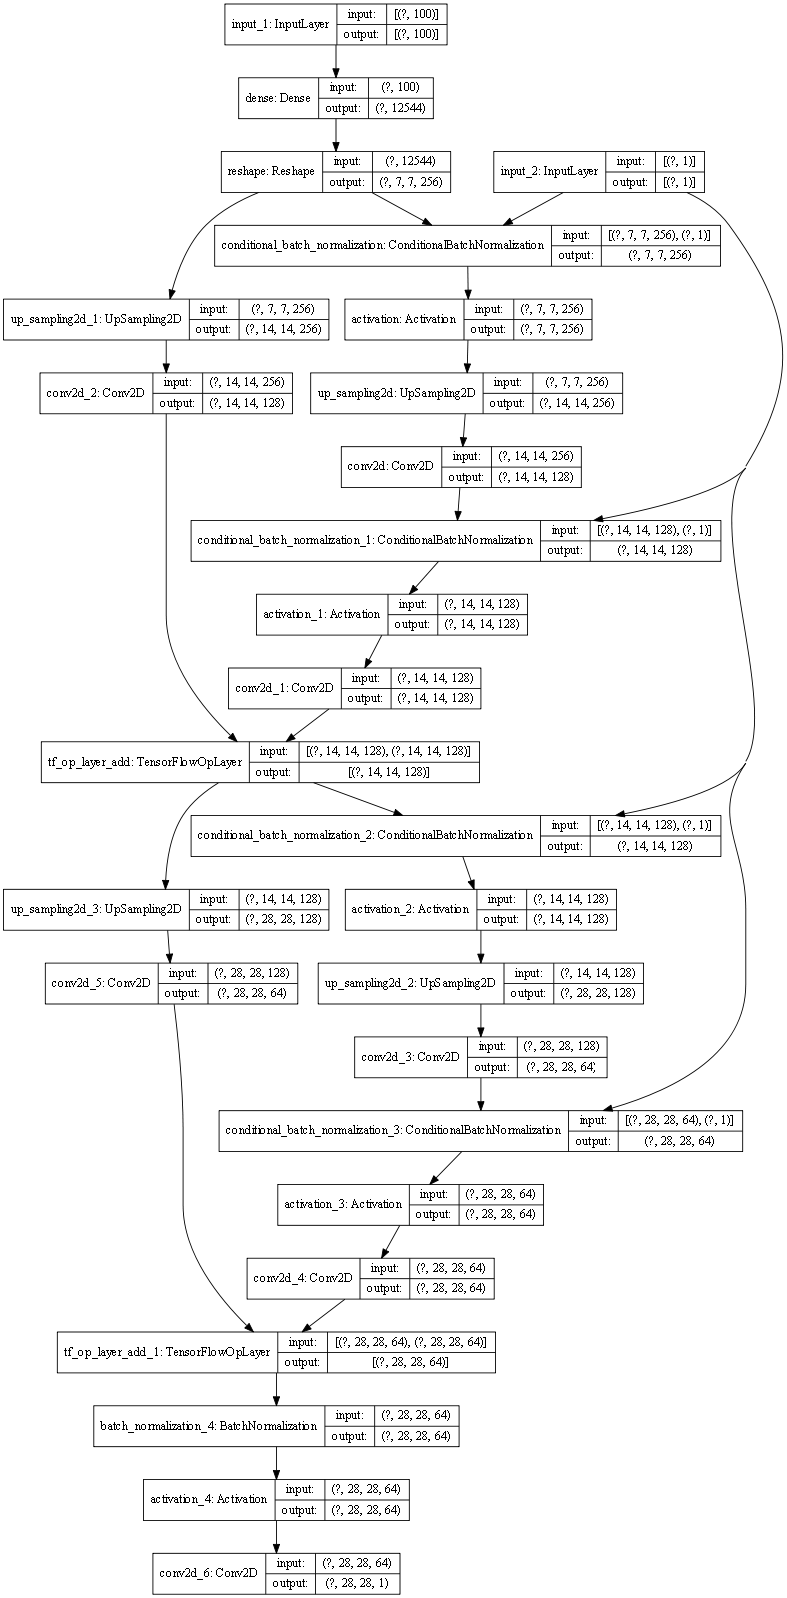

In [19]:
generator.summary()
plot_model(generator, show_shapes=True, dpi=64)

In [20]:
discriminator = CGAN_discriminator()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
spectral_normalization (Spectra (None, 28, 28, 64)   704         input_3[0][0]                    
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 28, 28, 64)   0           spectral_normalization[0][0]     
__________________________________________________________________________________________________
spectral_normalization_1 (Spect (None, 28, 28, 64)   36992       activation_5[0][0]               
____________________________________________________________________________________________

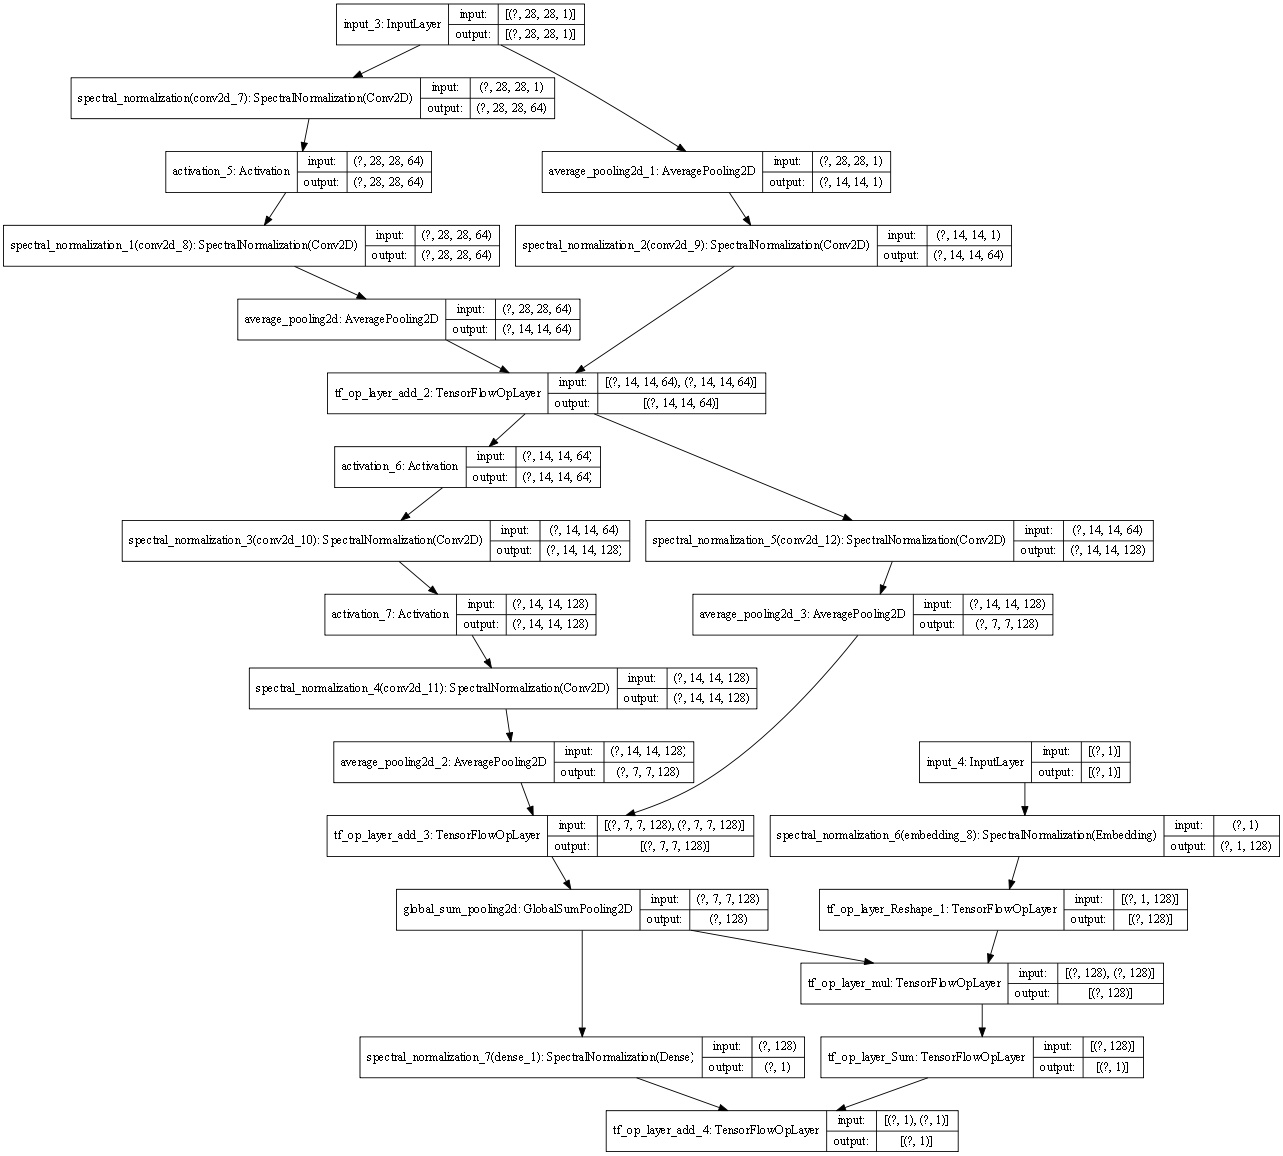

In [21]:
discriminator.summary()
plot_model(discriminator, show_shapes=True, dpi=64)

In [22]:
train_data = tf.data.Dataset.from_tensor_slices((train_data, oh_labels, labels)).repeat().shuffle(len(train_data)).batch(BATCH_SIZE)

In [23]:
D_optimizer = Adam(learning_rate=LR, beta_1=BETA_1, beta_2=BETA_2)
G_optimizer = Adam(learning_rate=LR, beta_1=BETA_1, beta_2=BETA_2)

def learning_rate_decay(current_lr, decay_factor=DECAY_FACTOR):
    new_lr = max(current_lr / decay_factor, MIN_LR)
    return new_lr

def set_learning_rate(new_lr):
    '''
        Set new learning rate to optimizers
    '''
    
    K.set_value(D_optimizer.lr, new_lr)
    K.set_value(G_optimizer.lr, new_lr)

In [24]:
# DC LOSS

# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# def discriminator_loss(real_output, fake_output):
#     real_loss = cross_entropy(tf.ones_like(real_output), real_output)
#     fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
#     total_loss = real_loss + fake_loss
#     return total_loss

# def generator_loss(fake_output):
#     return cross_entropy(tf.ones_like(fake_output), fake_output)

# def discriminator_loss(real_output, fake_output):
#     real_loss = tf.reduce_mean(tf.math.softplus(-real_output))
#     fake_loss = tf.reduce_mean(tf.math.softplus(fake_output))
#     total_loss = real_loss + fake_loss
#     return total_loss

# def generator_loss(fake_output):
#     return tf.reduce_mean(tf.math.softplus(-fake_output))

#Hinge loss
def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(real_output) - real_output))
    fake_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(fake_output) + fake_output))
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

In [25]:
checkpoint_path = os.path.join("checkpoints", "tensorflow")

ckpt = tf.train.Checkpoint(generator=generator,
                           discriminator=discriminator,
                           G_optimizer=G_optimizer,
                           D_optimizer=D_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    latest_epoch = int(ckpt_manager.latest_checkpoint.split('-')[1])
    CURRENT_EPOCH = latest_epoch * SAVE_EVERY_N_EPOCH
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))

In [26]:
def generate_and_save_images(model, epoch, test_input, save=True, is_flatten=True):
    # Test input is a list include noise and label
    predictions = model.predict(test_input)
    if is_flatten:
        predictions = predictions.reshape(-1, 28, 28, 1).astype('float32')
    fig = plt.figure(figsize=(3,3))
    for i in range(predictions.shape[0]):
        plt.subplot(3, 3, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    if save:
        plt.savefig(os.path.join(OUTPUT_PATH, 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

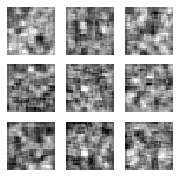

In [27]:
num_examples_to_generate = 9

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
sample_noise = tf.random.normal([num_examples_to_generate, NOISE_DIM])
sample_label = np.arange(0, 9).reshape(9, 1)
generate_and_save_images(generator, 0, [sample_noise, sample_label], save=False, is_flatten=False)

In [29]:
@tf.function
def train_d_step(real_image, real_label, batch_size, step):
    '''
        One training D step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    print("retrace")
    noise = tf.random.normal([batch_size, NOISE_DIM])
    # Open a GradientTape to record the operations run
    # during the forward pass, which enables autodifferentiation.
    with tf.GradientTape(persistent=True) as tape:
        fake_image = generator([noise, real_label], training=True)
        
        real_pred = discriminator([real_image, real_label], training=True)
        fake_pred = discriminator([fake_image, real_label], training=True)
        
        D_loss = discriminator_loss(real_pred, fake_pred)
    # Calculate the gradients for discriminator
    D_gradients = tape.gradient(D_loss, 
                                            discriminator.trainable_variables)

    # Apply the gradients to the optimizer
    D_optimizer.apply_gradients(zip(D_gradients,
                                                discriminator.trainable_variables))
    
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('D_loss', D_loss, step=step)
            
@tf.function
def train_g_step(real_image, real_label, batch_size, step):
    '''
        One training G step
        
        Reference: https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    print("retrace")
    noise = tf.random.normal([batch_size, NOISE_DIM])
    # Open a GradientTape to record the operations run
    # during the forward pass, which enables autodifferentiation.
    with tf.GradientTape(persistent=True) as tape:
        fake_image = generator([noise, real_label], training=True)
        
        fake_pred = discriminator([fake_image, real_label], training=True)
        
        G_loss = generator_loss(fake_pred)
    # Calculate the gradients for discriminator
    G_gradients = tape.gradient(G_loss, 
                                        generator.trainable_variables)

    # Apply the gradients to the optimizer
    G_optimizer.apply_gradients(zip(G_gradients, 
                                            generator.trainable_variables))
    
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('G_loss', G_loss, step=step)

Current iterations: 100001


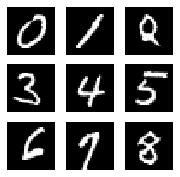

Saving checkpoint for epoch 100001 at checkpoints\tensorflow\ckpt-20
Time taken for 5000 iters is 161.6469268798828 sec

Saving checkpoint for epoch 100001 at checkpoints\tensorflow\ckpt-21


In [30]:
current_learning_rate = LR
trace = True
d_training_count = 0
start = time.time()

for step, (image, oh_label, label) in enumerate(train_data):
    if step > DECAY_ITERATIONS:
        current_learning_rate = learning_rate_decay(current_learning_rate)
        set_learning_rate(current_learning_rate)
    
    batch_size = tf.constant(label.shape[0], dtype=tf.int32)
    train_d_step(image, label, batch_size, step=tf.constant(step, dtype=tf.int64))
    d_training_count += 1
    if d_training_count >= D_G_TRAINING_RATIO:
        train_g_step(image, label, batch_size, step=tf.constant(step, dtype=tf.int64))
        d_training_count = 0

    if step % 10 == 0:
        print ('.', end='')
    
    if step % (SAVE_EVERY_N_ITER / 2) == 0 and step != 0:
        # Clear jupyter notebook cell output
        clear_output(wait=True)
        # Using a consistent image (sample_X) so that the progress of the model is clearly visible.
        print ('Current iterations: {}'.format(CURRENT_ITERATION))
        generate_and_save_images(generator, CURRENT_ITERATION, [sample_noise, sample_label], save=True)
    
    if step % SAVE_EVERY_N_ITER == 0 and step != 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(CURRENT_ITERATION,
                                                             ckpt_save_path))
    
        print ('Time taken for {} iters is {} sec\n'.format(SAVE_EVERY_N_ITER,
                                                          time.time()-start))
        start = time.time()
        
    if CURRENT_ITERATION > ITERATIONS:
        # Save at final
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(CURRENT_ITERATION,
                                                                ckpt_save_path))
        break
    CURRENT_ITERATION += 1